# Statistics II. Exam

In [194]:
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics

In [2]:
np.set_printoptions(linewidth=1000)

In [121]:
df_raw = pd.read_csv("data/cardio_train.csv", sep=';') 

In [116]:
# df_raw = df_raw.loc[np.random.randint(0, 70000, size=300), :]

## 0. Remove outliers

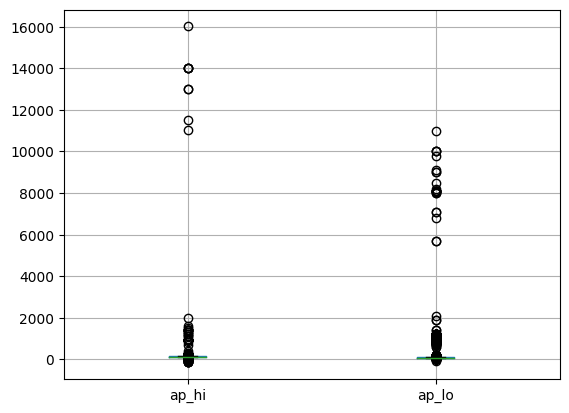

In [122]:
df_raw[["ap_hi", "ap_lo"]].boxplot()
plt.show()

Clearly blood pressure cannot be of the order of thousands, so those values are definitely some noise. Let's remove it

In [123]:
df= df_raw[
    (df_raw.ap_hi > df_raw.ap_hi.quantile(0.1)) 
    & (df_raw.ap_hi < df_raw.ap_hi.quantile(0.9))
    & (df_raw.ap_lo > df_raw.ap_lo.quantile(0.1)) 
    & (df_raw.ap_lo < df_raw.ap_lo.quantile(0.9))]

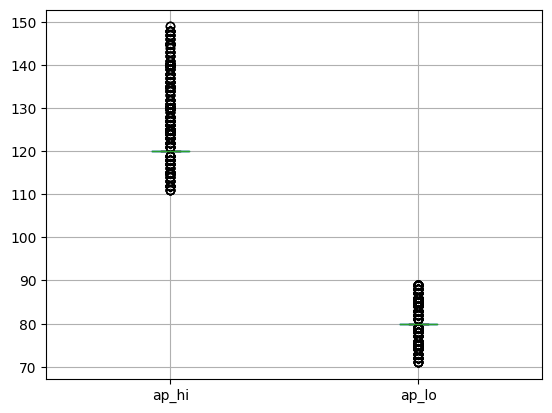

In [124]:
df[["ap_hi", "ap_lo"]].boxplot()
plt.show()

## 1. Normality check 

KstestResult(statistic=0.06362133899388367, pvalue=6.018699221155761e-113, statistic_location=170, statistic_sign=1)
KstestResult(statistic=0.09063782924163988, pvalue=5.29975420159763e-229, statistic_location=70.0, statistic_sign=1)
KstestResult(statistic=0.4510095344343968, pvalue=0.0, statistic_location=120, statistic_sign=1)
KstestResult(statistic=0.5006468555577266, pvalue=0.0, statistic_location=80, statistic_sign=1)


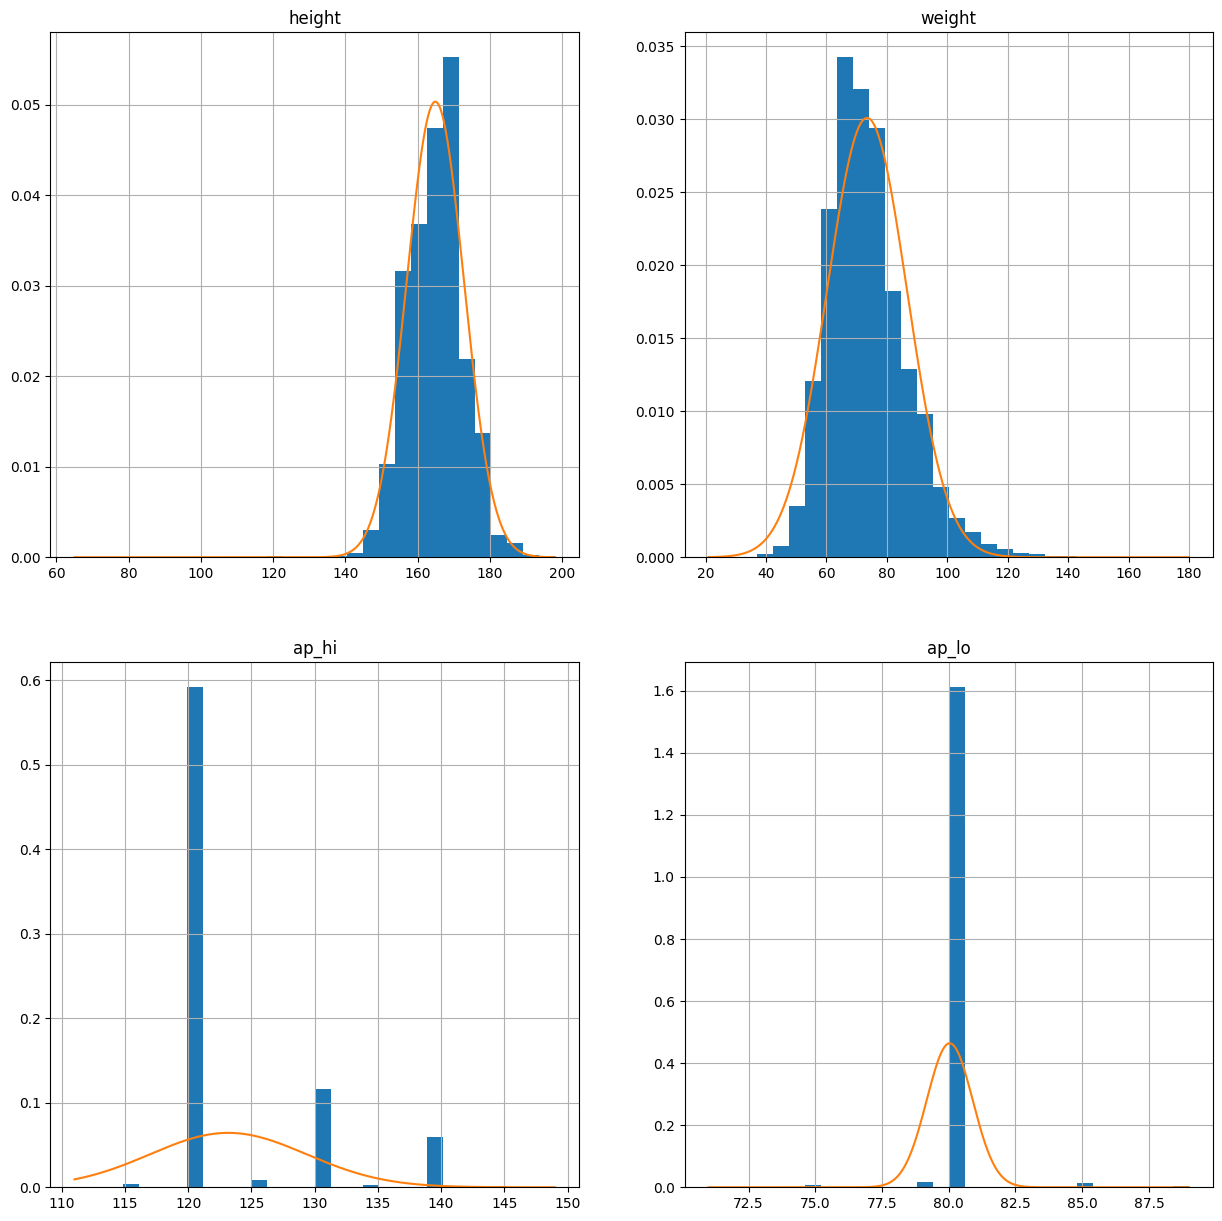

In [125]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))

cols = ["height", "weight", "ap_hi", "ap_lo"]

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        k = i * ncols + j
        col = cols[k]
    
        x = np.linspace(df[col].min(), df[col].max(), 1000)
        df[col].hist(bins=30, density=True, ax=ax)
        ax.plot(x, sci.stats.norm.pdf(x, df[col].mean(), df[col].std()))
        ax.set_title(f"{col}")

        res = sci.stats.kstest(df[col], cdf='norm', args=(df[col].mean(), df[col].std()))
        print(res)

plt.show()

Although from the KS test we should conclude that all four hypothesises about normality should be rejected, from the histograms we can suspect that `height` and `weight` are faitly close to normal distributions. Since in the task we need some normal-distributed features, let's assume that it's those two columns.

Small demonstration that KS test may fail on large datasets with truncated tails

In [144]:
a = np.random.normal(100, 10, size=100000)
l, h = np.quantile(a, 0.01), np.quantile(a, 0.99)
b = a[(a > l) & (a < h)]
sci.stats.kstest(b, cdf='norm', args=(b.mean(), b.std()))

KstestResult(statistic=0.010673804847575574, pvalue=3.979139906285287e-10, statistic_location=93.1753136604028, statistic_sign=1)

[Here](https://towardsdatascience.com/stop-testing-for-normality-dba96bb73f90) is a good post, which shortly explained why normality tests for large data sets not neccessary shows proper results


## 2. Classification 

### Classification with height and weight

In [195]:
x_cols = ['height', 'weight']
y_true = df['gender']
gnb = GaussianNB()
gnb.fit(df[x_cols], y_true)
y_pred = gnb.predict(df[x_cols])

In [196]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.89      0.82     20464
           2       0.72      0.50      0.59     11507

    accuracy                           0.75     31971
   macro avg       0.74      0.69      0.70     31971
weighted avg       0.74      0.75      0.74     31971



### Classification with ap_hi and ap_lo

In [197]:
x_cols = ['ap_hi', 'ap_lo']
y_true = df['gender']
gnb = GaussianNB()
gnb.fit(df[x_cols], y_true)
y_pred = gnb.predict(df[x_cols])

In [202]:
(y_pred == 1).all()

True

In [199]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.64      1.00      0.78     20464
           2       0.00      0.00      0.00     11507

    accuracy                           0.64     31971
   macro avg       0.32      0.50      0.39     31971
weighted avg       0.41      0.64      0.50     31971



/home/evgeniy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/evgeniy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/evgeniy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Regression

Doing simple linear regression for the cathegorical output may be not very good idea, but since the task is formulated in such a way let's try it

In [165]:
model = LinearRegression()
model.fit(df[cols], df['gender'])

LinearRegression()

In [166]:
y_pred = model.predict(df[cols])
y_true = df['gender']

In [167]:
metrics.r2_score(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

(0.21807661448676807, 0.1801376120375781)

Let's try to perform logistic regression instead

In [191]:
model = LogisticRegression()
model.fit(df[cols], y_true)
y_pred = model.predict(df[cols])

In [193]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.88      0.82     20464
           2       0.71      0.53      0.61     11507

    accuracy                           0.75     31971
   macro avg       0.74      0.71      0.71     31971
weighted avg       0.75      0.75      0.74     31971



## 4. Clusters analysis

As we suspect two clusters here (men and women), let's perform PCA and see if we can observe those clusters on the two principal components projection 

In [169]:
pca = PCA(n_components=2)
X_r = pca.fit(df[cols]).transform(df[cols])

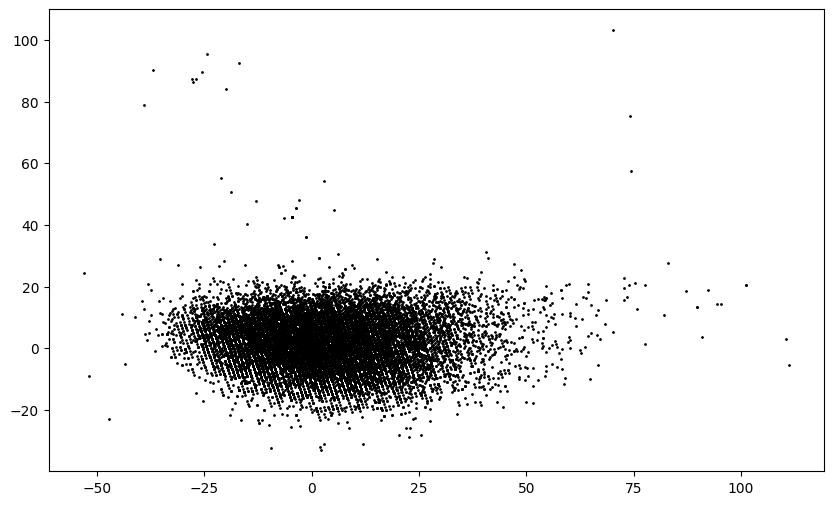

In [187]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(*X_r.T, s=1, color='black')
plt.show()

In [178]:
pca.explained_variance_ratio_

array([0.6629897 , 0.20522777])

Doesn't seem like we can spot clusters visually. Let's perform kmeans analysis.

In [180]:
estimators = {
    "kmeans_2": KMeans(n_clusters=2, init="k-means++"),
    "kmeans_3": KMeans(n_clusters=3, init="k-means++"),
    "kmeans_5": KMeans(n_clusters=5, init="k-means++")
}

In [181]:
labels = {}
for title, est in estimators.items():
    est.fit(df[cols])
    labels[title] = est.labels_

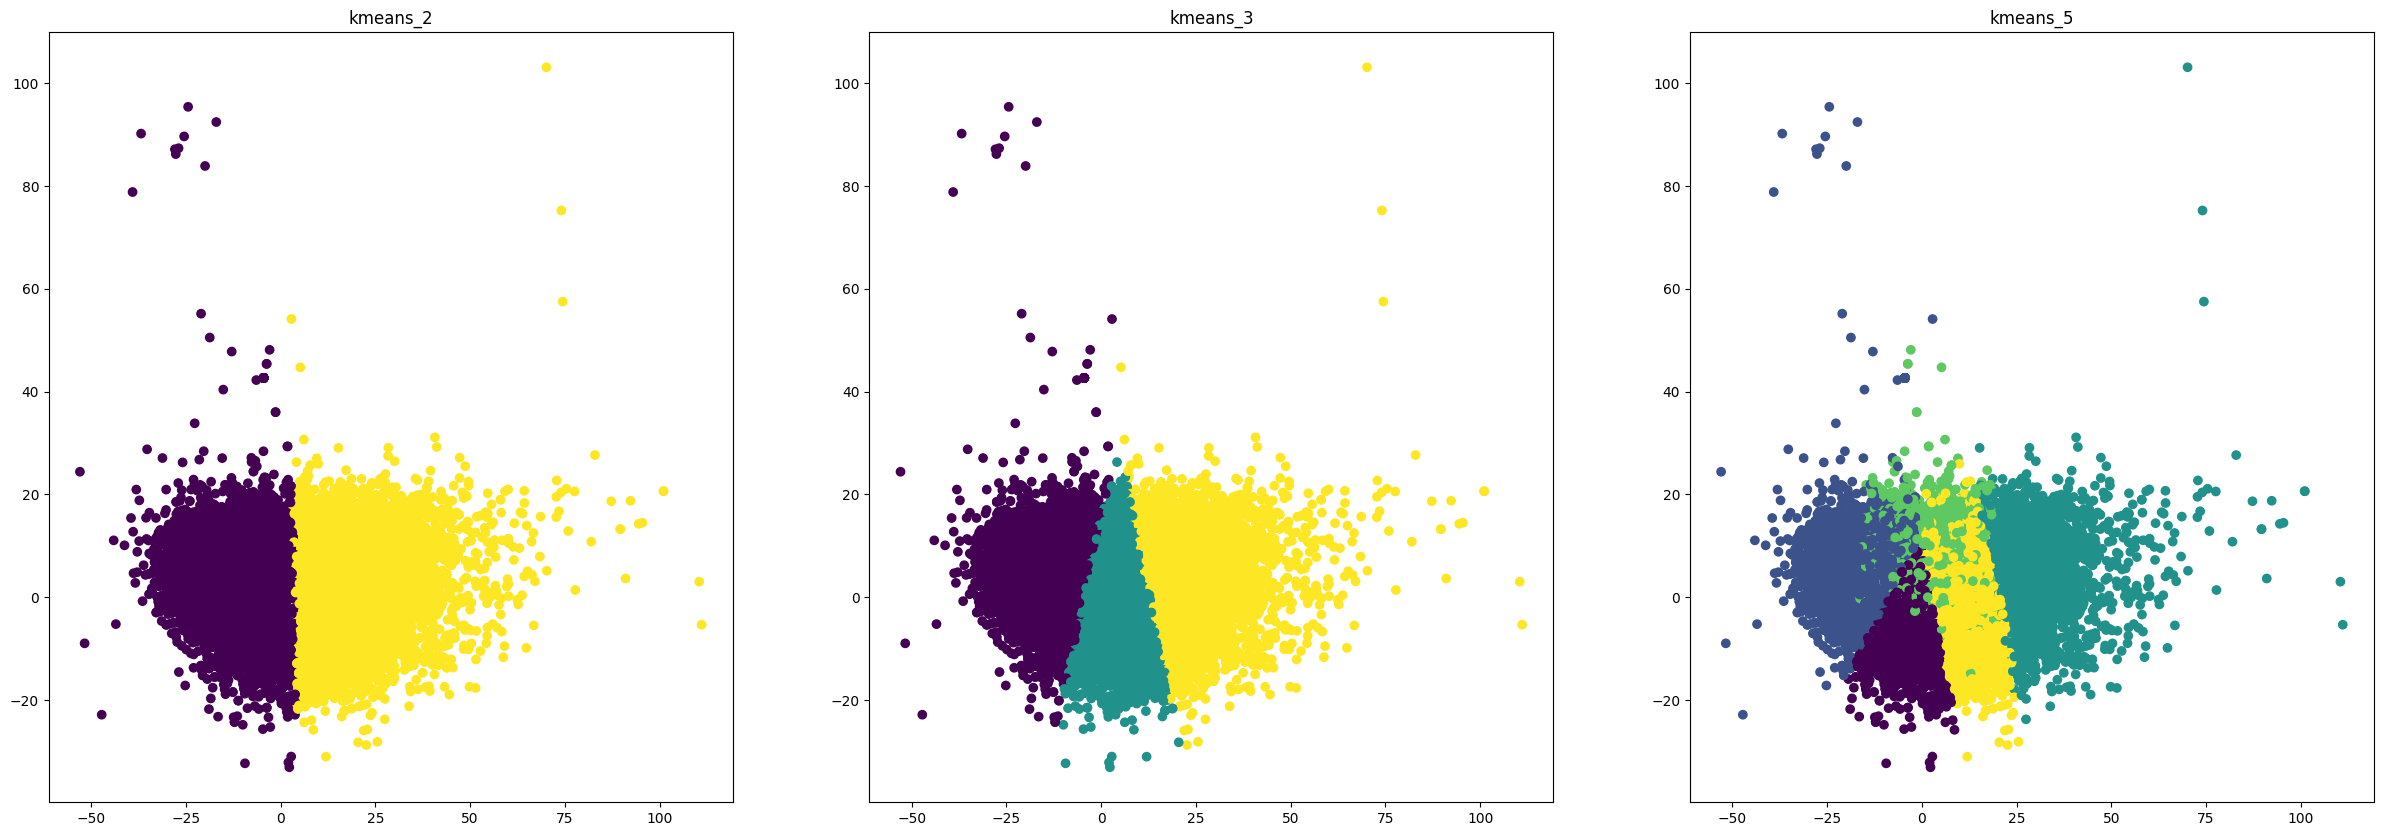

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

for i, title in enumerate(estimators.keys()):
    ax = axs[i]
    ax.scatter(*X_r.T, c=labels[title])
    ax.set_title(title)

plt.show()